# Preprocessing

In [1]:
import pyremo

In [2]:
import xarray as xr

In [3]:
#from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress

In [4]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40148 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 244.14 GiB


In [5]:
import intake
%matplotlib
url = "/pool/data/Catalogs/mistral-cmip6-cmip.json"
#pangeo_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
%time cat = intake.open_esm_datastore(url)
%time cat

Using matplotlib backend: agg
CPU times: user 17.5 s, sys: 1.69 s, total: 19.2 s
Wall time: 21.7 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


,unique
activity_id,1
institution_id,31
source_id,65
experiment_id,15
member_id,201
table_id,38
variable_id,1124
grid_label,11
dcpp_init_year,0
version,470


In [6]:
def possible_downscaling(cat, activity_id='CMIP', experiment_id='historical', member_id='r1i1p1f1', 
                         variable_id=['ta', 'ua', 'va', 'ps', 'hus', 'tos']):
    subset = cat.search(experiment_id=experiment_id, 
                        activity_id=activity_id,
                        member_id = member_id,
                        table_id=['6hrLev', 'Oday']).search(variable_id=variable_id, 
                                                            require_all_on='source_id')
    return subset

In [7]:
subset = possible_downscaling(cat)

In [8]:
subset.df.groupby(['source_id', 'experiment_id', 'table_id', 'version'])['variable_id'].unique().apply(list).to_frame()

variable_id
source_id       experiment_id table_id version                         
AWI-ESM-1-1-LR  historical    6hrLev   v20200212  [hus, ps, ta, ua, va]
                              Oday     v20200212                  [tos]
IPSL-CM6A-LR    historical    6hrLev   v20180803  [hus, ps, ta, ua, va]
                              Oday     v20180803                  [tos]
MPI-ESM-1-2-HAM historical    6hrLev   v20190627          [hus, ps, ta]
                                       v20190628               [ua, va]
                              Oday     v20190627                  [tos]
MPI-ESM1-2-HR   historical    6hrLev   v20190710          [hus, ps, ta]
                                       v20190815               [ua, va]
                              Oday     v20190710                  [tos]
MPI-ESM1-2-LR   historical    6hrLev   v20190710          [hus, ps, ta]
                                       v20190815               [ua, va]
                              Oday     v20190710                  [tos]
MRI-ESM2-0      historical    6hrLev   v20190625  [hus, ps, ta, ua, va]
                              Oday     v20191210                  [tos]
NorESM2-MM      historical    6hrLev   v20191108  [hus, ps, ta, ua, va]
                              Oday     v20191108                  [tos]

In [9]:
model_data_catalog = subset.search(source_id = 'MPI-ESM1-2-HR')

In [10]:
model_data_catalog.df.groupby(['source_id', 'experiment_id', 'table_id', 'member_id', 'version'])['variable_id'].unique().apply(list).to_frame()

variable_id
source_id     experiment_id table_id member_id version                 
MPI-ESM1-2-HR historical    6hrLev   r1i1p1f1  v20190710  [hus, ps, ta]
                                               v20190815       [ua, va]
                            Oday     r1i1p1f1  v20190710          [tos]

In [11]:
def open_mfdataset(files, use_cftime=True, parallel=True, data_vars='minimal', chunks={'time':1}, 
                   coords='minimal', compat='override', drop=None, **kwargs):
    """optimized function for opening CMIP6 6hrLev 3d datasets

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115
    
    """
    def drop_all_coords(ds):
        #ds = ds.drop(drop)
        return ds.reset_coords(drop=True)
    ds = xr.open_mfdataset(files, parallel=parallel, decode_times=False, combine='by_coords', 
                       preprocess=drop_all_coords, decode_cf=False, chunks=chunks,
                      data_vars=data_vars, coords='minimal', compat='override', **kwargs)
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [12]:
files = list(model_data_catalog.search(variable_id='ta').df.path)
files.sort()

In [13]:
%time ds = open_mfdataset(files, chunks='auto')

CPU times: user 13.1 s, sys: 1.29 s, total: 14.4 s
Wall time: 1min 33s


In [16]:
ds.nbytes / 1.e12 # TB

6.824784674264

In [14]:
from pyintorg import interface as intf

In [106]:
#lamem, phiem =               intf.geo_coords(domain_info['ll_lon'], domain_info['ll_lat'], 
#                                             domain_info['dlon'], domain_info['dlat'],
#                                             domain_info['pollon'], domain_info['pollat'],
#                                             domain_info['nlon'], domain_info['nlat'])

#### test

In [126]:
ta = ds.sel(time="1979-01-01T00:00:00")
ta

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 192, lev: 95, lon: 384, time: 1)
Coordinates:
  * time      (time) object 1979-01-01 00:00:00
  * lev       (lev) float64 0.9961 0.9826 0.959 ... 3.079e-05 2.31e-05 9.816e-06
  * lat       (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon       (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 1.0 0.9923 0.9923 ... 1.963e-05 1.963e-05 0.0
    ap        (lev) float64 0.0 0.0 36.03 171.8 ... 4.061 3.119 2.341 0.9946
    b         (lev) float64 0.9961 0.9826 0.9586 0.9259 ... 0.0 0.0 0.0 0.0
    ps        (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    ap_bnds   (lev, bnds) float64 0.0 0.0 0.0 0.0 0.0 ... 2.693 1.989 1.989 0.0
    b_bnds    (lev, bnds) float64 1.0 0.9923 0.9923 0.973 ... 0.0 0.0 0.0 0.0
    lat_bnds  (lat, bnds) float64 -89.75 -88.82 -88.82 ... 88.82 88.82 89.75
    lon_bnds  (lon, bnds) float64 -0.4688 0.4688 0.4688 ... 358.6 358.6 359.5
    ta        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 19, 32, 64), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/4f97de3c-435e-4644-ab10-7a8ae8e1b78c

In [15]:
from pyintorg import interface as intf

import numpy as np

def get_coords(lon, lat):
    if len(lon.shape) == 2 and len(lat.shape == 2):
        return lon.T * 1.0/57.296, lat.T * 1.0/57.296
    else:
        lon2d = np.stack([lon]*lat.size).T * 1.0/57.296
        lat2d = np.tile(lat, (lon.size,1)) * 1.0/57.296  
        return lon2d, lat2d

def spatial_dims(da):
    for dim in da.dims:
        if 'lon' in dim:
            lon_dim = dim
        if 'lat' in dim:
            lat_dim = dim
    return (lon_dim, lat_dim)

def interp_horiz_2d(field, lamgm, phigm, lamem, phiem, indii, indjj, name):
    """interpolates 2d global data horizontally.

    Interpolates 2d data from the global grid to the regional grid.
    """
    from intorg import intorg
    #if indii is None or indjj is None:
    #    indii, indjj = intersection_points(lamgm, phigm, lamem, phiem)
    return intorg.hiobla(field, lamgm, phigm, lamem, phiem, indii, indjj, name)


def intersect(lamgm, phigm, lamem, phiem):
    gcm_dims = list(spatial_dims(lamgm))
    rcm_dims = list(spatial_dims(lamem))
    rcm_dims.append('pos')
    out_dims = rcm_dims
    #print(gcm_dims)
    #print(rcm_dims)
    #print(out_dims)
    result = xr.apply_ufunc(
        intf.intersection_points,  # first the function
        lamgm*1.0/57.296,  # now arguments in the order expected by 'druint'
        phigm*1.0/57.296,
        lamem*1.0/57.296,
        phiem*1.0/57.296,
        input_core_dims=[gcm_dims, gcm_dims, rcm_dims, rcm_dims],  # list with one entry per arg
        output_core_dims=[out_dims, out_dims],  # returned data has 3 dimensions
     #   vectorize=True,  # loop over non-core dims, in this case: time
     #   exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        output_dtypes=[lamgm.dtype]
    )
    return result



def interp_horiz(da, lamgm, phigm, lamem, phiem, indii, indjj, name, keep_attrs=False): 
    """main interface"""
    gcm_dims = list(spatial_dims(lamgm))
    rcm_dims = list(spatial_dims(lamem))
    #lev_dims.append("lev")
    plev_dims = list(spatial_dims(da))
    plev_dims.append("plev")
    #nlev = a.dims[0]
    input_core_dims = [gcm_dims, gcm_dims, gcm_dims, rcm_dims, rcm_dims , rcm_dims, rcm_dims, [] ]
    print(input_core_dims)
    result = xr.apply_ufunc(
        interp_horiz_2d,  # first the function
        da,  # now arguments in the order expected
        lamgm*1.0/57.296,
        phigm*1.0/57.296,
        lamem*1.0/57.296,
        phiem*1.0/57.296,
        indii,
        indjj,
        name,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=[rcm_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
      #  exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[da.dtype]
    )

    result.name = name
    #result = result.to_dataset()
    if keep_attrs:
        result.attrs = da.attrs
    #result = result.transpose(..., *spatial_dims(da)[::-1])
    return result

#lamem, phiem = intf.geo_coords(domain_info['ll_lon'], domain_info['ll_lat'], 
#                               domain_info['dlon'], domain_info['dlat'],
#                               domain_info['pollon'], domain_info['pollat'],
#                               domain_info['nlon'], domain_info['nlat'])

from pyremo import domain as dm
domain = dm.remo_domain('EUR-11')
#domain_info = dm.domain_info('AFR-11')

lamem, phiem = domain.lon, domain.lat
lamem = xr.concat([lamem, lamem, lamem], dim='pos')
phiem = xr.concat([phiem, phiem, phiem], dim='pos')

lat2d, lon2d = xr.broadcast(ds.lat, ds.lon)

lamgm, phigm = lon2d, lat2d

indii, indjj = intersect(lamgm, phigm, lamem, phiem)

In [16]:
ta.ta.isel(lev=0).plot()

NameError: name 'ta' is not defined

In [371]:
ta_interp = interp_horiz(ta.ta, lamgm, phigm, 
                         lamem.isel(pos=0), phiem.isel(pos=0), 
                         indii.isel(pos=0), indjj.isel(pos=0), 'T')

[['lon', 'lat'], ['lon', 'lat'], ['lon', 'lat'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], []]


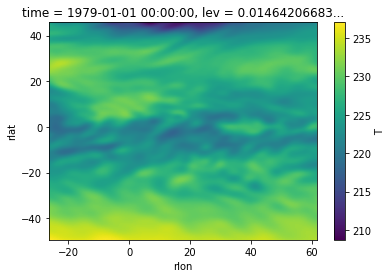

In [372]:
ta_interp.isel(lev=50).plot(x='rlon', y='rlat')

In [373]:
ta_interp = interp_horiz(ds.ta.sel(time="1979-01-01"), lamgm, phigm, 
                         lamem.isel(pos=0), phiem.isel(pos=0), 
                         indii.isel(pos=0), indjj.isel(pos=0), 'T')

[['lon', 'lat'], ['lon', 'lat'], ['lon', 'lat'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], []]


In [374]:
ta_interp

<xarray.DataArray 'T' (time: 4, lev: 95, rlon: 801, rlat: 865)>
dask.array<transpose, shape=(4, 95, 801, 865), dtype=float32, chunksize=(3, 19, 801, 865), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1979-01-01 00:00:00 ... 1979-01-01 18:00:00
  * lev      (lev) float64 0.9961 0.9826 0.959 ... 3.079e-05 2.31e-05 9.816e-06
  * rlon     (rlon) float64 -26.23 -26.12 -26.02 -25.91 ... 61.55 61.66 61.77
  * rlat     (rlat) float64 -49.34 -49.23 -49.12 -49.01 ... 45.49 45.6 45.71

In [375]:
%time ta_interp_ = ta_interp.persist()  # start computation
%time progress(ta_interp_)

CPU times: user 299 ms, sys: 22 ms, total: 321 ms
Wall time: 315 ms
CPU times: user 727 ms, sys: 100 ms, total: 827 ms
Wall time: 1.51 s


VBox()

In [17]:
filename = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ta/gn/v20190710/ta_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"

In [18]:
ds_single = open_mfdataset(filename)

In [19]:
ds_single

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 192, lev: 95, lon: 384, time: 1460)
Coordinates:
  * time      (time) object 1979-01-01 06:00:00 ... 1980-01-01 00:00:00
  * lev       (lev) float64 0.9961 0.9826 0.959 ... 3.079e-05 2.31e-05 9.816e-06
  * lat       (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon       (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 dask.array<chunksize=(95, 2), meta=np.ndarray>
    ap        (lev) float64 dask.array<chunksize=(95,), meta=np.ndarray>
    b         (lev) float64 dask.array<chunksize=(95,), meta=np.ndarray>
    ps        (time, lat, lon) float32 dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    ap_bnds   (lev, bnds) float64 dask.array<chunksize=(95, 2), meta=np.ndarray>
    b_bnds    (lev, bnds) float64 dask.array<chunksize=(95, 2), meta=np.ndarray>
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(384, 2), meta=np.ndarray>
    ta        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/e7cf2db1-51d1-4692-a1ff-60e2d204b533

In [20]:
ta_interp = interp_horiz(ds_single.ta.sel(time="1979-01"), lamgm, phigm, 
                         lamem.isel(pos=0), phiem.isel(pos=0), 
                         indii.isel(pos=0), indjj.isel(pos=0), 'T')

[['lon', 'lat'], ['lon', 'lat'], ['lon', 'lat'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], []]


In [21]:
ta_interp

,Array,Chunk
Bytes,8.16 GiB,67.95 MiB
Shape,"(123, 95, 433, 433)","(1, 95, 433, 433)"
Count,3543 Tasks,123 Chunks
Type,float32,numpy.ndarray


In [22]:
%time ta_interp_ = ta_interp.persist()  # start computation
%time progress(ta_interp_)

CPU times: user 74 ms, sys: 3 ms, total: 77 ms
Wall time: 74.5 ms
CPU times: user 378 ms, sys: 83 ms, total: 461 ms
Wall time: 878 ms


VBox()

In [403]:
ta_interp_

,Array,Chunk
Bytes,8.16 GiB,67.95 MiB
Shape,"(123, 95, 433, 433)","(1, 95, 433, 433)"
Count,123 Tasks,123 Chunks
Type,float32,numpy.ndarray


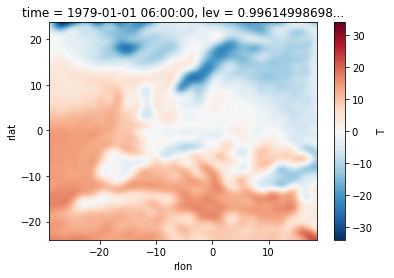

In [404]:
(ta_interp_.isel(lev=0, time=0)-273.5).plot(x='rlon', y='rlat')